In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install -q mtcnn
!pip install -q lz4


In [2]:
import os
ages=[]
gender=[]
img_path=[]
BASE_DIR='/kaggle/input/utk-dataset/utkface_aligned_cropped/UTKFace'
for file in os.listdir(BASE_DIR):
    if file.endswith(".jpg"):
        parts = file.split("_")
        ages.append(int(parts[0]))
        gender.append(int(parts[1]))
        img_path.append(os.path.join(BASE_DIR, file))

In [3]:
import pandas as pd

df = pd.DataFrame({
    "path": img_path,
    "age": ages,
    "gender": gender
})

# remove extreme outliers
df = df[df["age"] < 80]

# reset index
df = df.reset_index(drop=True)

print(df.shape)
df.head()


(23035, 3)


,path,age,gender
0,/kaggle/input/utk-dataset/utkface_aligned_crop...,26,0
1,/kaggle/input/utk-dataset/utkface_aligned_crop...,22,1
2,/kaggle/input/utk-dataset/utkface_aligned_crop...,21,1
3,/kaggle/input/utk-dataset/utkface_aligned_crop...,28,0
4,/kaggle/input/utk-dataset/utkface_aligned_crop...,17,1


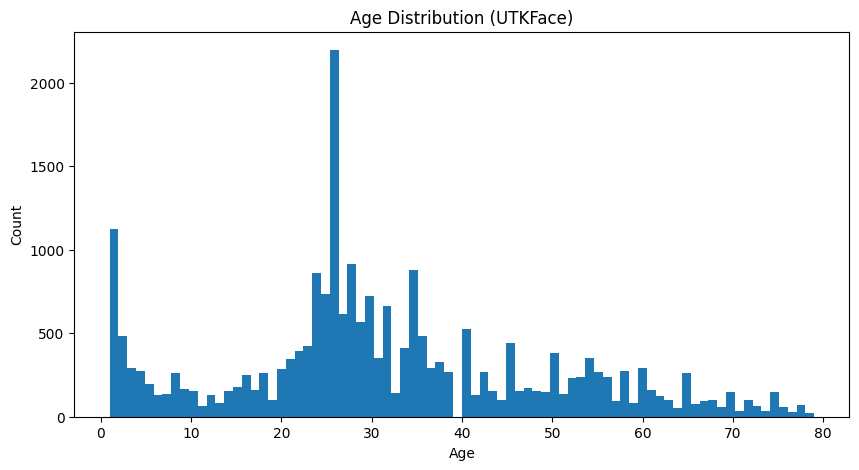

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(df["age"], bins=80)
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age Distribution (UTKFace)")
plt.show()


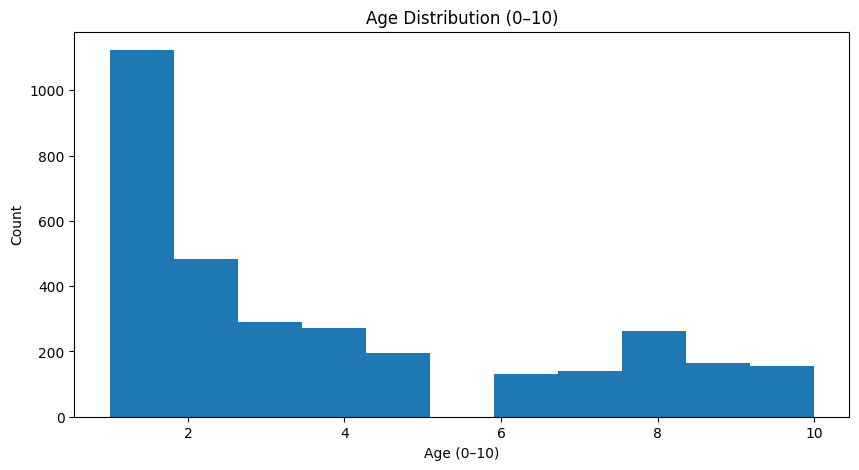

In [5]:
plt.figure(figsize=(10,5))
plt.hist(df[df["age"] <= 10]["age"], bins=11)
plt.xlabel("Age (0–10)")
plt.ylabel("Count")
plt.title("Age Distribution (0–10)")
plt.show()


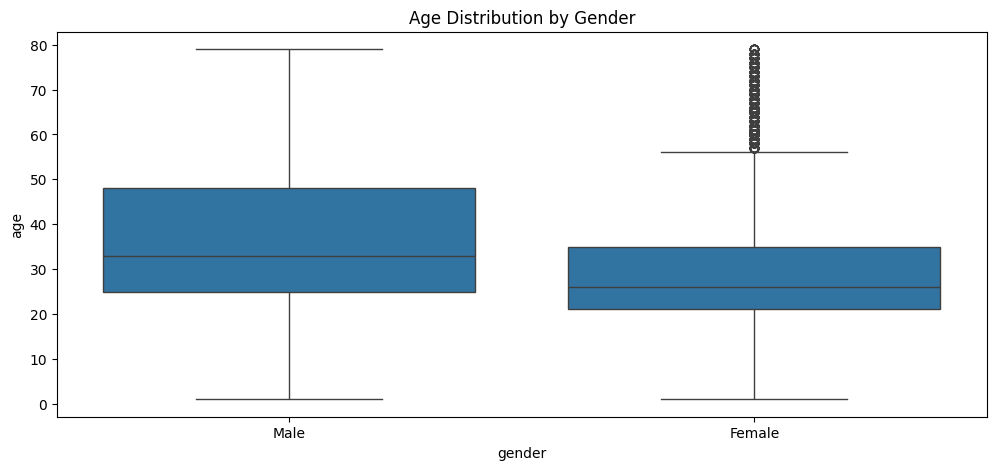

In [6]:
import seaborn as sns

plt.figure(figsize=(12,5))
sns.boxplot(x="gender", y="age", data=df)
plt.xticks([0,1], ["Male", "Female"])
plt.title("Age Distribution by Gender")
plt.show()


In [7]:
import mtcnn

2025-12-28 10:40:04.479864: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766918404.501495     557 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766918404.507987     557 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766918404.525092     557 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766918404.525111     557 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766918404.525114     557 computation_placer.cc:177] computation placer alr

In [8]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print("Train size:", train_df.shape)
print("Val size:", val_df.shape)


Train size: (18428, 3)
Val size: (4607, 3)


In [9]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input


In [10]:
IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE


In [11]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])


I0000 00:00:1766918407.202733     557 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [12]:
def load_train_img(path, age, gender):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32)

    img = preprocess_input(img)
    img = data_augmentation(img)

    return img, {
        "age": tf.cast(age, tf.float32),
        "gender": tf.cast(gender, tf.float32)
    }


In [13]:
def load_val_img(path, age, gender):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32)

    img = preprocess_input(img)

    return img, {
        "age": tf.cast(age, tf.float32),
        "gender": tf.cast(gender, tf.float32)
    }


In [14]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df["path"].values,
     train_df["age"].values,
     train_df["gender"].values)
)

val_ds = tf.data.Dataset.from_tensor_slices(
    (val_df["path"].values,
     val_df["age"].values,
     val_df["gender"].values)
)


In [15]:
train_ds = train_ds.map(load_train_img, num_parallel_calls=AUTOTUNE)
val_ds   = val_ds.map(load_val_img,   num_parallel_calls=AUTOTUNE)


In [16]:
train_ds = (
    train_ds
    .shuffle(1000)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_ds = (
    val_ds
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)


In [17]:
for images, labels in train_ds.take(1):
    print(images.shape)                 # (BATCH, 224, 224, 3)
    print(labels["age"].shape)          # (BATCH,)
    print(labels["gender"].shape)       # (BATCH,)


(32, 224, 224, 3)
(32,)
(32,)


In [18]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import (
    Input, Dense, Dropout, BatchNormalization,
    GlobalAveragePooling2D,Conv2D
)
from tensorflow.keras.models import Model


In [19]:
inputs = Input(shape=(224, 224, 3), name="image")


x = tf.keras.applications.resnet.preprocess_input(inputs)

base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_tensor=x
)

# Freeze backbone for stage-1 training
for layer in base_model.layers:
    layer.trainable = False


shared = base_model(x)



In [20]:
age_x = Conv2D(256, (3,3), padding="same", activation="relu")(shared)
age_x = BatchNormalization()(age_x)
age_x = GlobalAveragePooling2D()(age_x)
age_x = Dense(128, activation="relu")(age_x)
age_x = Dropout(0.3)(age_x)
age_x = Dense(32, activation="relu")(age_x)
age_x = Dropout(0.3)(age_x)
age_output = Dense(1, activation="relu", name="age")(age_x)

# Gender head
gender_x = Conv2D(128, (3,3), padding="same", activation="relu")(shared)
gender_x = BatchNormalization()(gender_x)
gender_x = GlobalAveragePooling2D()(gender_x)
gender_x = Dense(64, activation="relu")(gender_x)
gender_x = Dropout(0.3)(gender_x)
gender_x = Dense(16, activation="relu")(gender_x)
gender_x = Dropout(0.3)(gender_x)
gender_output = Dense(1, activation="sigmoid", name="gender")(gender_x)

In [21]:
model = Model(
    inputs=inputs,
    outputs=[age_output, gender_output]
)


In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss={
        "age": tf.keras.losses.Huber(delta=5.0),
        "gender": "binary_crossentropy"
    },
    loss_weights={
        "age": 1.0,
        "gender": 0.7
    },
    metrics={
        "age": "mae",
        "gender": [
            "accuracy",
            tf.keras.metrics.AUC(name="auc")
        ]
    }
)


In [23]:
EPOCHS_STAGE_1 = 5

history_stage_1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE_1
)


Epoch 1/5


I0000 00:00:1766918428.257859     594 service.cc:152] XLA service 0x78d174002510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766918428.257895     594 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1766918430.515639     594 cuda_dnn.cc:529] Loaded cuDNN version 91002


  2/576 ━━━━━━━━━━━━━━━━━━━━ 40s 71ms/step - age_loss: 161.2990 - age_mae: 34.6508 - gender_accuracy: 0.5234 - gender_auc: 0.5053 - gender_loss: 0.7001 - loss: 161.7890   

I0000 00:00:1766918437.435086     594 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


576/576 ━━━━━━━━━━━━━━━━━━━━ 151s 224ms/step - age_loss: 92.2688 - age_mae: 20.7656 - gender_accuracy: 0.7297 - gender_auc: 0.8059 - gender_loss: 0.5297 - loss: 92.6396 - val_age_loss: 37.6270 - val_age_mae: 9.7153 - val_gender_accuracy: 0.8285 - val_gender_auc: 0.9129 - val_gender_loss: 0.3730 - val_loss: 37.8889
Epoch 2/5
576/576 ━━━━━━━━━━━━━━━━━━━━ 116s 192ms/step - age_loss: 44.6132 - age_mae: 11.1041 - gender_accuracy: 0.8023 - gender_auc: 0.8858 - gender_loss: 0.4263 - loss: 44.9116 - val_age_loss: 29.4923 - val_age_mae: 7.9679 - val_gender_accuracy: 0.8409 - val_gender_auc: 0.9220 - val_gender_loss: 0.3538 - val_loss: 29.7410
Epoch 3/5
576/576 ━━━━━━━━━━━━━━━━━━━━ 116s 194ms/step - age_loss: 40.9785 - age_mae: 10.3420 - gender_accuracy: 0.8194 - gender_auc: 0.9008 - gender_loss: 0.3995 - loss: 41.2581 - val_age_loss: 31.6532 - val_age_mae: 8.4248 - val_gender_accuracy: 0.8504 - val_gender_auc: 0.9300 - val_gender_loss: 0.3348 - val_loss: 31.8885
Epoch 4/5
576/576 ━━━━━━━━━━━━━━

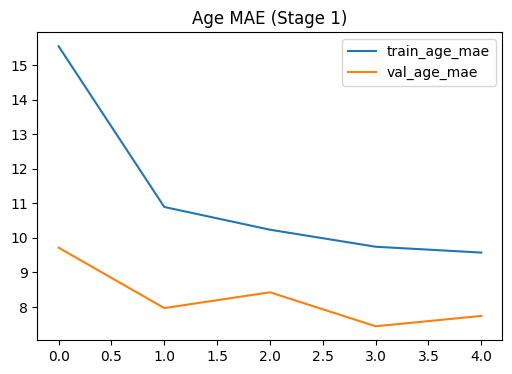

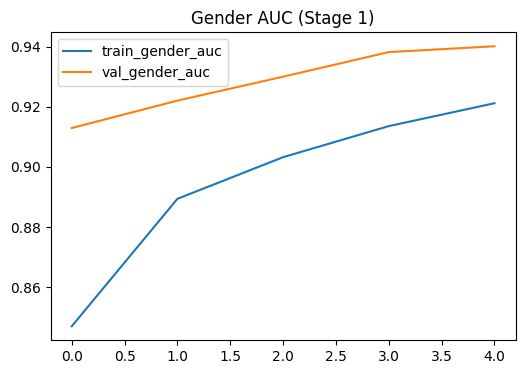

In [24]:
import matplotlib.pyplot as plt

# Age MAE
plt.figure(figsize=(6,4))
plt.plot(history_stage_1.history["age_mae"], label="train_age_mae")
plt.plot(history_stage_1.history["val_age_mae"], label="val_age_mae")
plt.legend()
plt.title("Age MAE (Stage 1)")
plt.show()

# Gender AUC
plt.figure(figsize=(6,4))
plt.plot(history_stage_1.history["gender_auc"], label="train_gender_auc")
plt.plot(history_stage_1.history["val_gender_auc"], label="val_gender_auc")
plt.legend()
plt.title("Gender AUC (Stage 1)")
plt.show()


In [25]:
# Unfreeze only the top ResNet block (conv5)
for layer in base_model.layers:
    if layer.name.startswith("conv5"):
        layer.trainable = True
    else:
        layer.trainable = False


In [26]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss={
        "age": tf.keras.losses.Huber(delta=3.0),
        "gender": "binary_crossentropy"
    },
    loss_weights={
        "age": 1.0,
        "gender": 0.7
    },
    metrics={
        "age": "mae",
        "gender": [
            "accuracy",
            tf.keras.metrics.AUC(name="auc")
        ]
    }
)


In [27]:
EPOCHS_STAGE_2 = 10

history_stage_2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE_2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_gender_auc",
            patience=4,
            mode="max",
            restore_best_weights=True
        )
    ]
)


Epoch 1/10
576/576 ━━━━━━━━━━━━━━━━━━━━ 167s 241ms/step - age_loss: 27.1638 - age_mae: 10.4153 - gender_accuracy: 0.8015 - gender_auc: 0.8873 - gender_loss: 0.4233 - loss: 27.4601 - val_age_loss: 17.8125 - val_age_mae: 7.2311 - val_gender_accuracy: 0.8478 - val_gender_auc: 0.9236 - val_gender_loss: 0.3528 - val_loss: 18.0603
Epoch 2/10
576/576 ━━━━━━━━━━━━━━━━━━━━ 126s 211ms/step - age_loss: 23.9437 - age_mae: 9.3265 - gender_accuracy: 0.8329 - gender_auc: 0.9127 - gender_loss: 0.3773 - loss: 24.2078 - val_age_loss: 16.9477 - val_age_mae: 6.9441 - val_gender_accuracy: 0.8513 - val_gender_auc: 0.9292 - val_gender_loss: 0.3395 - val_loss: 17.1863
Epoch 3/10
576/576 ━━━━━━━━━━━━━━━━━━━━ 127s 212ms/step - age_loss: 23.2533 - age_mae: 9.0979 - gender_accuracy: 0.8358 - gender_auc: 0.9192 - gender_loss: 0.3621 - loss: 23.5068 - val_age_loss: 16.3599 - val_age_mae: 6.7378 - val_gender_accuracy: 0.8541 - val_gender_auc: 0.9338 - val_gender_loss: 0.3303 - val_loss: 16.5920
Epoch 4/10
576/576 ━━

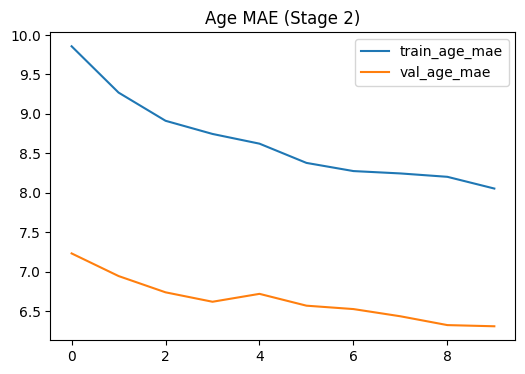

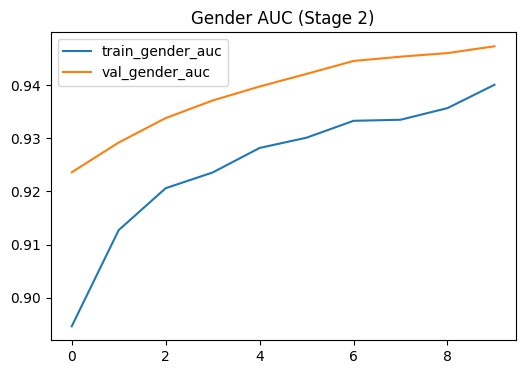

In [28]:
# Age MAE
plt.figure(figsize=(6,4))
plt.plot(history_stage_2.history["age_mae"], label="train_age_mae")
plt.plot(history_stage_2.history["val_age_mae"], label="val_age_mae")
plt.legend()
plt.title("Age MAE (Stage 2)")
plt.show()

# Gender AUC
plt.figure(figsize=(6,4))
plt.plot(history_stage_2.history["gender_auc"], label="train_gender_auc")
plt.plot(history_stage_2.history["val_gender_auc"], label="val_gender_auc")
plt.legend()
plt.title("Gender AUC (Stage 2)")
plt.show()


In [29]:

import gradio as gr
import numpy as np
from PIL import Image
from mtcnn import MTCNN
from tensorflow.keras.applications.resnet50 import preprocess_input


In [30]:
detector = MTCNN()


In [31]:
def detect_and_crop_face(image):
    """
    image: PIL.Image
    returns: cropped PIL.Image (face) or None
    """
    img_np = np.array(image.convert("RGB"))
    results = detector.detect_faces(img_np)

    if len(results) == 0:
        return None

    # pick face with highest confidence
    results = sorted(results, key=lambda x: x["confidence"], reverse=True)
    x, y, w, h = results[0]["box"]

    x, y = max(0, x), max(0, y)
    face = img_np[y:y+h, x:x+w]

    if face.size == 0:
        return None

    return Image.fromarray(face)


In [32]:
def preprocess_image(image):
    image = image.convert("RGB")
    img = image.resize((224, 224))
    img = np.array(img).astype("float32")
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img


In [33]:
def predict_with_face_detection(image):
    """
    image: PIL.Image (from Gradio)
    """
    face = detect_and_crop_face(image)

    if face is None:
        return {
            "Error": "No face detected. Please upload a clear frontal face image."
        }

    img = preprocess_image(face)

    age_pred, gender_pred = model.predict(img, verbose=0)

    age = float(age_pred[0][0])
    gender_prob = float(gender_pred[0][0])

    if 0.45 <= gender_prob <= 0.55:
        gender = "Uncertain"
    else:
        gender = "Female" if gender_prob >= 0.5 else "Male"

    return {
        "Predicted Age": round(age, 1),
        "Predicted Gender": gender,
        "Gender Probability (%)": round(gender_prob * 100, 2)
    }


In [34]:
interface = gr.Interface(
    fn=predict_with_face_detection,
    inputs=gr.Image(type="pil", label="Upload Face Image"),
    outputs=gr.JSON(label="Prediction"),
    title="Age & Gender Prediction System",
    description=(
        "CNN-based age and gender prediction using a fine-tuned ResNet50 backbone. "
        "Face is automatically detected using MTCNN before prediction."
    ),
    allow_flagging="never"
)


/usr/local/lib/python3.12/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


In [35]:
interface.launch()


* Running on local URL:  http://127.0.0.1:7860
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://e644f4b53f88477f47.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
df.head()